In [2]:
import numpy as np
import pandas as pd
import warnings
import os

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.compat.v1.keras.layers import TimeDistributed
#from tensorflow.keras.layers import Conv1D
#from tensorflow.keras.layers import MaxPooling1D
#from tensorflow.keras.layers import ConvLSTM2D

warnings.simplefilter('ignore')

countryName = 'Brazil'

nFeatures = 1

nDaysMin = 7
k = 7

nValid = 10
nTest = 10

In [3]:
dataDir = os.path.join('C:\\Users\\AMC\\Desktop\\Roshi\\Data')
confirmedFilename = 'confirmed_july.csv'
deathsFilename = 'deaths_july.csv'
recoveredFilename = 'recovered_july.csv'

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps, k):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix + k >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+k]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def meanAbsolutePercentageError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    absPcErrorList = [absError/yTrue for absError, yTrue in zip(absErrorList, yTrueList)]
    MAPE = 100*np.mean(absPcErrorList)
    return MAPE

def meanAbsolutePercentageError_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
            
    # Get MAPE for each day in a list
    MAPEList = []
    for i in yTrueForDayK.keys():
        MAPEList.append(meanAbsolutePercentageError(yTrueForDayK[i], yPredForDayK[i]))
    return np.mean(MAPEList)

def meanForecastError(yTrueList, yPredList):
    forecastErrors = [yTrue - yPred for yTrue, yPred in zip(yTrueList, yPredList)]
    MFE = np.mean(forecastErrors)
    return MFE

def meanAbsoluteError(yTrueList, yPredList):
    absErrorList = [np.abs(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(absErrorList)

def meanSquaredError(yTrueList, yPredList):
    sqErrorList = [np.square(yTrue - yPred) for yTrue, yPred in zip(yTrueList, yPredList)]
    return np.mean(sqErrorList)

def rootMeanSquaredError(yTrueList, yPredList):
    return np.sqrt(meanSquaredError(yTrueList, yPredList))
def medianSymmetricAccuracy(yTrueList, yPredList):
    '''https://helda.helsinki.fi//bitstream/handle/10138/312261/2017SW001669.pdf?sequence=1'''
    logAccRatioList = [np.abs(np.log(yPred/yTrue)) for yTrue, yPred in zip(yTrueList, yPredList)]
    MdSA = 100*(np.exp(np.median(logAccRatioList))-1)
    return MdSA

def medianSymmetricAccuracy_kDay(yTrueListList, yPredListList):
    # Store true and predictions for day 1 in a list, day 2 in a list and so on
    # Keep each list of these lists in a respective dict with key as day #
    yTrueForDayK = {}
    yPredForDayK = {}
    for i in range(len(yTrueListList[0])):
        yTrueForDayK[i] = []
        yPredForDayK[i] = []
    for yTrueList, yPredList in zip(yTrueListList, yPredListList):
        for i in range(len(yTrueList)):
            yTrueForDayK[i].append(yTrueList[i])
            yPredForDayK[i].append(yPredList[i])
    # Get MdSA for each day in a list
    MdSAList = []
    for i in yTrueForDayK.keys():
        MdSAList.append(medianSymmetricAccuracy(yTrueForDayK[i], yPredForDayK[i]))
    return(np.mean(MdSAList))

In [6]:
# Get all the frames for a country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

In [7]:
# Load all 3 csv files
covidFrDict = {}
covidFrDict['confirmed'] = pd.read_csv(confirmedFilename)
covidFrDict['deaths'] = pd.read_csv(deathsFilename)
covidFrDict['recovered'] = pd.read_csv(recoveredFilename)

countryCovidFrDict = getCountryCovidFrDict(countryName)

# List of dates
colNamesList = list(countryCovidFrDict['confirmed'])
dateList = [colName for colName in colNamesList if '/20' in colName]
dataList = [countryCovidFrDict['confirmed'][date].iloc[0] for date in dateList]
dataDict = dict(zip(dateList, dataList))

# Only take time series from where the cases were >100
daysSince = 100
nCasesGreaterDaysSinceList = []
datesGreaterDaysSinceList = []

for key in dataDict.keys():
    if dataDict[key] > daysSince:
        datesGreaterDaysSinceList.append(key)
        nCasesGreaterDaysSinceList.append(dataDict[key])
        
XList, yList = split_sequence(nCasesGreaterDaysSinceList, nDaysMin, k)

XTrainList = XList[0:len(XList)-(nValid + nTest)]
XValidList = XList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
XTestList = XList[-nTest:]

yTrain = yList[0:len(XList)-(nValid + nTest)]
yValid = yList[len(XList)-(nValid+nTest):len(XList)-(nTest)]
yTest = yList[-nTest:]
print('Total size of data points for LSTM:', len(yList))
print('Size of training set:', len(yTrain))
print('Size of validation set:', len(yValid))
print('Size of test set:', len(yTest))
type(yTrain)
XTrainList

Total size of data points for LSTM: 124
Size of training set: 104
Size of validation set: 10
Size of test set: 10


array([[    151,     151,     162,     200,     321,     372,     621],
       [    151,     162,     200,     321,     372,     621,     793],
       [    162,     200,     321,     372,     621,     793,    1021],
       [    200,     321,     372,     621,     793,    1021,    1546],
       [    321,     372,     621,     793,    1021,    1546,    1924],
       [    372,     621,     793,    1021,    1546,    1924,    2247],
       [    621,     793,    1021,    1546,    1924,    2247,    2554],
       [    793,    1021,    1546,    1924,    2247,    2554,    2985],
       [   1021,    1546,    1924,    2247,    2554,    2985,    3417],
       [   1546,    1924,    2247,    2554,    2985,    3417,    3904],
       [   1924,    2247,    2554,    2985,    3417,    3904,    4256],
       [   2247,    2554,    2985,    3417,    3904,    4256,    4579],
       [   2554,    2985,    3417,    3904,    4256,    4579,    5717],
       [   2985,    3417,    3904,    4256,    4579,    5717,   

In [8]:
# Convert the list to matrix
XTrain = XTrainList.reshape((XTrainList.shape[0], XTrainList.shape[1], nFeatures))
XValid = XValidList.reshape((XValidList.shape[0], XValidList.shape[1], nFeatures))
XTest = XTestList.reshape((XTestList.shape[0], XTestList.shape[1], nFeatures))

In [9]:
#ax = XTrain.plt(figsize=(10,12))
#XTest.plt(ax=ax)
#plt.legend(['train', 'test'])
#plt.show()

In [10]:
type(XTrain)
len(XTrain)
XTrain

array([[[    151],
        [    151],
        [    162],
        [    200],
        [    321],
        [    372],
        [    621]],

       [[    151],
        [    162],
        [    200],
        [    321],
        [    372],
        [    621],
        [    793]],

       [[    162],
        [    200],
        [    321],
        [    372],
        [    621],
        [    793],
        [   1021]],

       [[    200],
        [    321],
        [    372],
        [    621],
        [    793],
        [   1021],
        [   1546]],

       [[    321],
        [    372],
        [    621],
        [    793],
        [   1021],
        [   1546],
        [   1924]],

       [[    372],
        [    621],
        [    793],
        [   1021],
        [   1546],
        [   1924],
        [   2247]],

       [[    621],
        [    793],
        [   1021],
        [   1546],
        [   1924],
        [   2247],
        [   2554]],

       [[    793],
        [   1021],
        [   1546]

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

nNeurons = 100 # number of neurones
nFeatures = 1  # number of features

bestValidMAPE = 100# 100 validation for best MAPE
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    
    # define model
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    #train_mse, test_mse = list(), list()
    history = model.fit(XTrain, yTrain[:,0], epochs=500, verbose=0)
    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')
model.summary()

history1= model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=500, verbose=0)
     

0 4.6496976226066185
Updating best MAPE to 4.6496976226066185...
Updating best seed to 0...
1 5.10571424340258
2 3.9754110516570114
Updating best MAPE to 3.9754110516570114...
Updating best seed to 2...
3 3.105212231248622
Updating best MAPE to 3.105212231248622...
Updating best seed to 3...
4 4.163343065485934
5 4.33687845484786
6 99.99098153364523
7 0.876238482100903
Updating best MAPE to 0.876238482100903...
Updating best seed to 7...
8 8.650839139659452
9 5.476813372431915
10 5.079554058609107
11 6.823525025162616
12 99.98996533681814
13 4.978152180216591
14 1.1474816939685668
15 99.99072381028454
16 3.6361040964760596
17 4.792808181591197
18 4.315926907249038
19 13.86553333859979
20 1.03049575810623
21 6.096317532089985
22 6.7978495990295675
23 7.350396477031848
24 6.981399013151078
25 7.609993693703066
26 14.594145344409748
27 6.065295399150155
28 99.98958253578516
29 5.360143994695526
30 1.8763661353614454
31 2.640995260471097
32 2.8088576191568526
33 8.495657930185091
34 1.4438

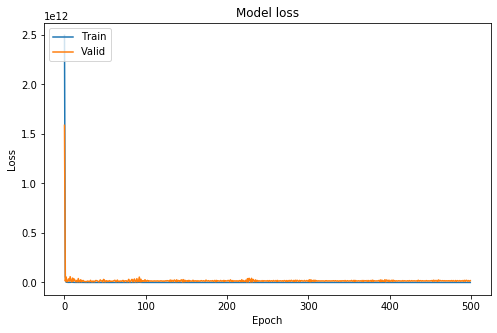

In [12]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [13]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
#pyplot(history['train'], color = 'blue')
#pyplot(history['test'], color = 'orange')
yPredVanilla = yPredListList 

Test MAPE: 1.205772352806987
Test MdSA: 1.1235857447135051
Test MSE: 1186500528.8276787
Test RMSE: 34445.61697557004


In [14]:
RMSE = rootMeanSquaredError(yTest, yPredListList[-1])
print('Test RMSE:', RMSE)

Test RMSE: 202199.49742760116


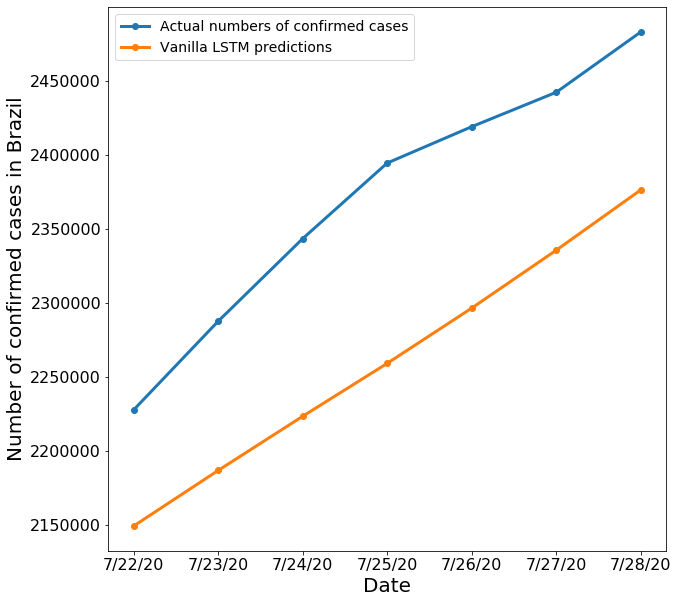

In [15]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
#plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
#plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
#ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
#plt.savefig(os.path.join('Plots_3days_k7', 'predictions_{}.png'.format(countryName)), dpi=400)

# Stacked LSTM

In [16]:
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
    model.add(LSTM(nNeurons, activation='relu'))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)
        
        
#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)

    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
        
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(LSTM(nNeurons, activation='relu', return_sequences=True, input_shape=(nDaysMin, nFeatures)))
model.add(LSTM(nNeurons, activation='relu'))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history1 = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 77.25830524901313
Updating best MAPE to 77.25830524901313...
Updating best seed to 0...
1 99.98598840505841
2 82.32451986891212
3 4.234513166392634
Updating best MAPE to 4.234513166392634...
Updating best seed to 3...
4 8.475168906350996
5 3.6998761961603583
Updating best MAPE to 3.6998761961603583...
Updating best seed to 5...
6 77.91981388951021
7 80.6758860041248
8 80.67480857934387
9 75.62509258109027
10 99.9782112571402
11 100.0135990539837
12 79.66904053384424
13 99.9978701971738
14 81.487914614017
15 13.879705027063746
16 24.237515800189264
17 75.17681642223718
18 76.6957918883876
19 nan
20 78.72485610082295
21 80.5833925479313
22 81.22473541752859
23 81.48091401544045
24 76.63257527624127
25 79.4192767846281
26 99.99739752140013
27 99.98022378258551
28 81.08806044531839
29 80.32323085082932
30 80.07176842695854
31 76.52617824787474
32 77.43217533866057
33 6.765225449163672
34 80.54283025617872
35 8.989717256855263
36 80.953456897687
37 4.762278512642484
38 163741.08678771483


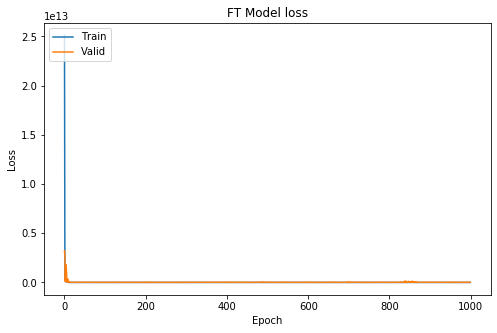

In [17]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('FT Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [18]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredStacked = yPredListList

Test MAPE: 1.0892628691476012
Test MdSA: 0.9818429786800856
Test MSE: 1108139302.2368305
Test RMSE: 33288.726353479346


# Bi-directional LSTM

In [19]:
# define model
nNeurons = 50
nFeatures = 1

bestValidMAPE = 100
bestSeed = -1
for seed in range(100):
    tf.random.set_seed(seed=seed)
    model = Sequential()
    model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mse')

    # fit model
    history = model.fit(XTrain, yTrain[:,0], epochs=1000, verbose=0)

    yPredListList = []
    for day in range(nTest):
        yPredListList.append([])
    XValidNew = XValid.copy()
    for day in range(k):
        yPred = model.predict(np.float32(XValidNew), verbose=0)
        for i in range(len(yPred)):
            yPredListList[i].append(yPred[i][0])
        XValidNew = np.delete(XValidNew, 0, axis=1)
        yPred = np.expand_dims(yPred, 2)
        XValidNew = np.append(XValidNew, yPred, axis=1)

#     for yTrue, yPred in zip(yTest, yPredList):
#         print(yTrue, yPred)
    MAPE = meanAbsolutePercentageError_kDay(yValid, yPredListList)
    print(seed, MAPE)
    if MAPE < bestValidMAPE:
        print('Updating best MAPE to {}...'.format(MAPE))
        bestValidMAPE = MAPE
        print('Updating best seed to {}...'.format(seed))
        bestSeed = seed
# define model
print('Training model with best seed...')
tf.random.set_seed(seed=bestSeed)
model = Sequential()
model.add(Bidirectional(LSTM(nNeurons, activation='relu'), input_shape=(nDaysMin, nFeatures)))
model.add(Dense(1))
opt = Adam(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse')

# fit model
history1 = model.fit(XTrain, yTrain[:,0], validation_data = (XValid, yValid), epochs=1000, verbose=0)



0 35.56098359270235
Updating best MAPE to 35.56098359270235...
Updating best seed to 0...
1 17.061135311187805
Updating best MAPE to 17.061135311187805...
Updating best seed to 1...
2 99.9814620944431
3 39.50702255916122
4 4.692587116308898
Updating best MAPE to 4.692587116308898...
Updating best seed to 4...
5 27.538968611414045
6 5.152800871381688
7 0.9025172356108605
Updating best MAPE to 0.9025172356108605...
Updating best seed to 7...
8 3.4336655643578036
9 5.273050175644997
10 99.97820007845597
11 3.072505903268755
12 1.4642280582219573
13 99.98053690708238
14 1.7128849919489568
15 7.557540486924525
16 3.9334899027044155
17 5.455660045059212
18 1.3152243318868544
19 5.078817627293886
20 9.121361214365436
21 3.4176819110412717
22 3.571036448498938
23 0.9988697256493102
24 6.933212096331334
25 4.129397382063517
26 6.854597818397366
27 4.054396676013729
28 0.8931394891690403
Updating best MAPE to 0.8931394891690403...
Updating best seed to 28...
29 10.879116382404517
30 99.978780172

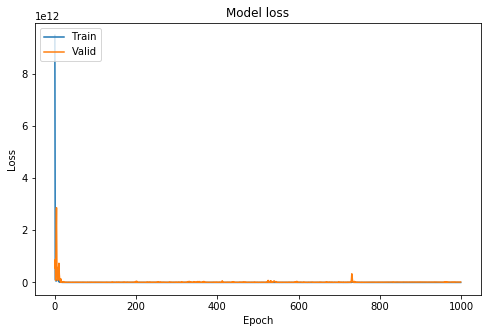

<Figure size 432x288 with 0 Axes>

In [20]:
#diagnostic plots
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.savefig(os.path.join('Plots_7days_k7_new_loss', 'loss_bilstm{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_7days_k7_new_loss', 'loss_bilstm{}.pdf'.format(countryName)), dpi=400)

In [21]:
yPredListList = []
for day in range(nTest):
    yPredListList.append([])
XTestNew = XTest.copy()
for day in range(k):
    yPred = model.predict(np.float32(XTestNew), verbose=0)
    for i in range(len(yPred)):
        yPredListList[i].append(yPred[i][0])
    XTestNew = np.delete(XTestNew, 0, axis=1)
    yPred = np.expand_dims(yPred, 2)
    XTestNew = np.append(XTestNew, yPred, axis=1)
    
MAPE = meanAbsolutePercentageError_kDay(yTest, yPredListList)
print('Test MAPE:', MAPE)
MdSA = medianSymmetricAccuracy_kDay(yTest, yPredListList)
print('Test MdSA:', MdSA)
MSE = meanSquaredError(yTest, yPredListList)
print('Test MSE:', MSE)
RMSE = rootMeanSquaredError(yTest, yPredListList)
print('Test RMSE:', RMSE)
yPredBidirectional = yPredListList
#Test MAPE: 1.7792816617564429
#Test MdSA: 1.804781887615706
#Test MSE: 2120930253.630357
#Test RMSE: 46053.55853384575

Test MAPE: 1.7792816617564429
Test MdSA: 1.804781887615706
Test MSE: 2120930253.630357
Test RMSE: 46053.55853384575


In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Format y tick labels
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

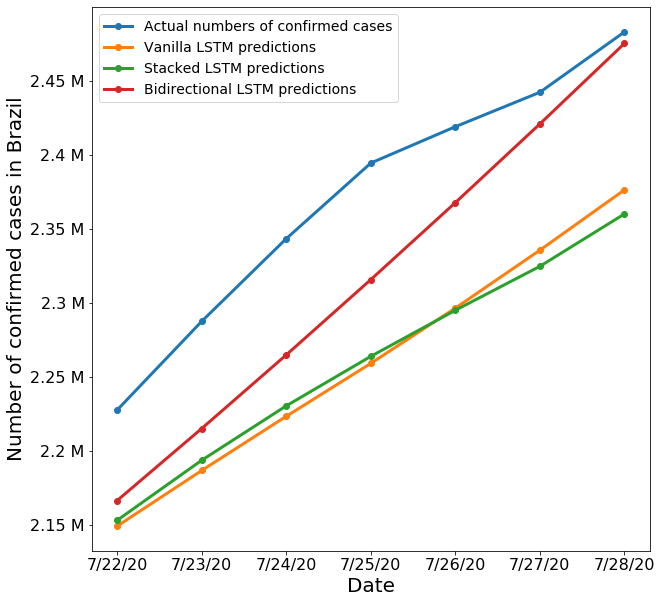

In [23]:
plt.figure(figsize=(10,10))
datesForPlottingList = datesGreaterDaysSinceList[-k:]
groundTruthList = nCasesGreaterDaysSinceList[-k:]


plt.ylabel('Number of confirmed cases in Brazil', fontsize=20)
plt.plot(datesForPlottingList, groundTruthList, '-o', linewidth=3, label='Actual numbers of confirmed cases');
plt.plot(datesForPlottingList, yPredVanilla[-1], '-o', linewidth=3, label='Vanilla LSTM predictions');
plt.plot(datesForPlottingList, yPredStacked[-1], '-o', linewidth=3, label='Stacked LSTM predictions');
plt.plot(datesForPlottingList, yPredBidirectional[-1], '-o', linewidth=3, label='Bidirectional LSTM predictions');
plt.xlabel('Date', fontsize=20);
plt.legend(fontsize=14);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
#date_form = DateFormatter("%d-%m")
#ax.xaxis.set_major_formatter(date_form)
# plt.grid(axis='y')
plt.savefig(os.path.join('Plots_7days_k7_new', 'predictions_{}.png'.format(countryName)), dpi=400)
plt.savefig(os.path.join('Plots_7days_k7_new', 'predictions_{}.pdf'.format(countryName)), dpi=400)

In [24]:
datesForPlottingList

['7/22/20', '7/23/20', '7/24/20', '7/25/20', '7/26/20', '7/27/20', '7/28/20']

In [25]:
groundTruthList 

[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

In [26]:
dataDict

{'1/22/20': 0,
 '1/23/20': 0,
 '1/24/20': 0,
 '1/25/20': 0,
 '1/26/20': 0,
 '1/27/20': 0,
 '1/28/20': 0,
 '1/29/20': 0,
 '1/30/20': 0,
 '1/31/20': 0,
 '2/1/20': 0,
 '2/2/20': 0,
 '2/3/20': 0,
 '2/4/20': 0,
 '2/5/20': 0,
 '2/6/20': 0,
 '2/7/20': 0,
 '2/8/20': 0,
 '2/9/20': 0,
 '2/10/20': 0,
 '2/11/20': 0,
 '2/12/20': 0,
 '2/13/20': 0,
 '2/14/20': 0,
 '2/15/20': 0,
 '2/16/20': 0,
 '2/17/20': 0,
 '2/18/20': 0,
 '2/19/20': 0,
 '2/20/20': 0,
 '2/21/20': 0,
 '2/22/20': 0,
 '2/23/20': 0,
 '2/24/20': 0,
 '2/25/20': 0,
 '2/26/20': 1,
 '2/27/20': 1,
 '2/28/20': 1,
 '2/29/20': 2,
 '3/1/20': 2,
 '3/2/20': 2,
 '3/3/20': 2,
 '3/4/20': 4,
 '3/5/20': 4,
 '3/6/20': 13,
 '3/7/20': 13,
 '3/8/20': 20,
 '3/9/20': 25,
 '3/10/20': 31,
 '3/11/20': 38,
 '3/12/20': 52,
 '3/13/20': 151,
 '3/14/20': 151,
 '3/15/20': 162,
 '3/16/20': 200,
 '3/17/20': 321,
 '3/18/20': 372,
 '3/19/20': 621,
 '3/20/20': 793,
 '3/21/20': 1021,
 '3/22/20': 1546,
 '3/23/20': 1924,
 '3/24/20': 2247,
 '3/25/20': 2554,
 '3/26/20': 2985,
 '

In [27]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla)
print('Test RMSE:', RMSE)

Test RMSE: 296134.68523617735


In [28]:
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked)
print('Test RMSE:', RMSE)

Test RMSE: 298125.3701797412


In [29]:
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional)
print('Test RMSE:', RMSE)

Test RMSE: 272383.5154321191


In [30]:
RMSE = rootMeanSquaredError(groundTruthList, yPredVanilla[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredStacked[-1])
print('Test RMSE:', RMSE)
RMSE = rootMeanSquaredError(groundTruthList, yPredBidirectional[-1])
print('Test RMSE:', RMSE)

Test RMSE: 111478.88174400054
Test RMSE: 112552.11640736386
Test RMSE: 59211.0499705593


In [31]:
groundTruthList
#[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

[2227514, 2287475, 2343366, 2394513, 2419091, 2442375, 2483191]

In [32]:
yPredVanilla[-1]
#[2148991.0, 2186593.2, 2223241.2, 2259038.0, 2296415.0, 2335580.8, 2376364.2]

[2148991.0, 2186593.2, 2223241.2, 2259038.0, 2296415.0, 2335580.8, 2376364.2]

In [33]:
yPredStacked[-1]
#[2152926.2, 2193526.8, 2230309.0, 2263786.0, 2294952.8, 2324670.0, 2360105.5]

[2152926.2, 2193526.8, 2230309.0, 2263786.0, 2294952.8, 2324670.0, 2360105.5]

In [34]:
yPredBidirectional[-1]
#[2166282.8, 2214988.5, 2264787.2, 2315703.5, 2367762.2, 2420989.2, 2475410.8]

[2166282.8, 2214988.5, 2264787.2, 2315703.5, 2367762.2, 2420989.2, 2475410.8]

In [32]:

# Function to get all three frames for a given country
def getCountryCovidFrDict(countryName):
    countryCovidFrDict = {}
    for key in covidFrDict.keys():
        dataFr = covidFrDict[key]
        countryCovidFrDict[key] = dataFr[dataFr['Country/Region'] == countryName]
    return countryCovidFrDict

# Function for plotting country data
def plotCountryData(countryName, logScale=False, every_nth=4):
    countryCovidFrDict = getCountryCovidFrDict(countryName)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    for key in countryCovidFrDict.keys():
        casesByDateDict = dict(countryCovidFrDict[key][dateList].sum(axis=0))
        # Stop drawing vertical lines on log scale when plotting zero
        if logScale:
            for dateKey in casesByDateDict.keys():
                if casesByDateDict[dateKey] == 0:
                    casesByDateDict[dateKey] = np.nan
        ax.plot(list(casesByDateDict.keys()), list(casesByDateDict.values()), marker='o', label=key);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);

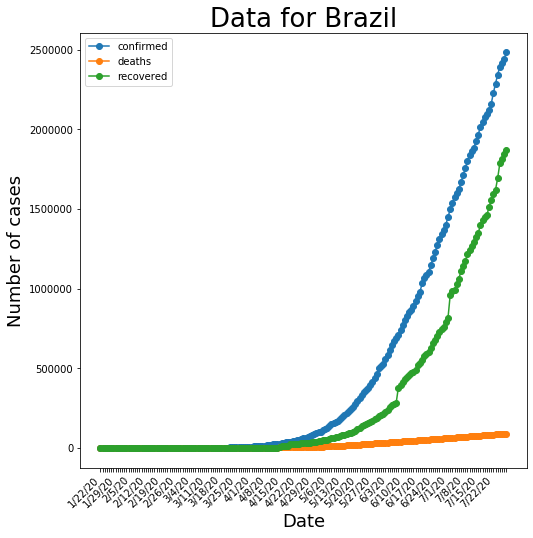

In [35]:

# Use logScale=True to plot in log scale on the y axis
plotCountryData('Brazil', logScale=False, every_nth=7)

In [49]:

def getPredictionsForFuture(countryName,
                            nDays=7,
                            invertible=False, # Whether model is invertible or not
                            plot=True,
                            logScale=False,
                            grid=None,
                            printResults=True,
                            tablesToUse='all',
                            returnResults=False,
                            every_nth=10):
            # Required for printing as well as plotting
        dateTimeOjectForPlotList = dateTimeOjectList.copy()
        lastDateTimeObject = dateTimeOjectForPlotList[-1]
        futureDateTimeObjectList = []
        for i in range(nDays):
            lastDateTimeObject += timedelta(days=1)
            dateTimeOjectForPlotList.append(lastDateTimeObject)
            futureDateTimeObjectList.append(lastDateTimeObject)

        datetimeForPlotList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in dateTimeOjectForPlotList]
        futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]
        if printResults:
            print('Predictions for next {} days:'.format(nDays))
            # Round off predictions for printing
            predPrintList = [np.around(elem) for elem in predictionsList]
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
            print(tabulate(datePredList, headers=['Date', 'Prediction'], tablefmt='orgtbl', floatfmt=".0f"))
            
                
        